# POV DREAMING EXPERIMENTS

In [141]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
# imports
import sys, os
sys.path.append('../../deep_dream_src/')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
from plot_utils import draw_smiles_linker, create_parity_plot
from nn_functions import featurize_df, prepare_hybrid_dataset, MolecularLSTMModel, prepare_dreaming_mof, prepare_dreaming_edge, split_dataframe
from utils import *
from tokenizer_functions import *
import selfies as sf
from group_selfies import GroupGrammar, bond_constraints
import math
import pickle 
group_constraints = {'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 3, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8, '*': math.inf, 'Fr': 1}
bond_constraints.set_semantic_constraints(group_constraints)
from dreaming_functions import *
import rdkit
rdkit.RDLogger.DisableLog('rdApp.warning')


### Collect input data

In [143]:
training_data = pd.read_csv('../../train_models/training_data.csv')
group_grammar = GroupGrammar.from_file('../gs_mof_grammar.txt')
training_data.head(1)

,edge_selfie,edge_canon_smile,edge_group_selfie,group_selfie_length,node_selfie,topo,SA_score,connection_point,MOFname,totalPOV_VF,...,GSA,henry_coefficient_CO2_300_mol_kg_Pa,log_henry_coefficient_CO2_300,heat_of_adsorption_CO2_300_kJ_mol,henry_coefficient_N2_300_mol_kg_Pa,log_henry_coefficient_N2_300,heat_of_adsorption_N2_300_kJ_mol,henry_CO2_N2_selectivity,log_CO2_N2_selectivity,filename
0,[O][O][C][=C][C][Branch1][C][Fr][C][Branch1][R...,OOC1=CC([Fr])C(OO)=CC1=C1NN([Fr])N1,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,28,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,acs,5.938156,"[11, 27]",acs_N125_edge1276,0.7545,...,4100.11,0.000005,-12.2,-10.097733,0.000002,-13.3,-4.43999,2.92,1.072161,acs_N125_edge1276.cif


In [144]:
target_names = ['totalPOV_VF']

mof_selfies_encoding, tokenized_info = featurize_df(
    training_data,
    target_names,
    edge_rep = 'edge_group_selfie',
    node_rep = 'node_selfie',
    topo_rep = 'topo'
    )

samples = 10000
split_by = {
    'method': 'sample',
    'train': samples,
    'validate': 1000,
    'test': 1000
    }

train_df, validate_df, test_df = split_dataframe(mof_selfies_encoding, split_by, seed=42)

c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\SARKISOV_GROUP_REPOs\dreaming4MOFs\deep_dreaming_experiments\1_POV\../../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\SARKISOV_GROUP_REPOs\dreaming4MOFs\deep_dreaming_experiments\1_POV\../../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

# Load Language Models

In [145]:
dream_name = f'LSTM_interval_noise_06_{target_names[0]}_11000samples_group_selfies'
predictor_name = f'LSTM_interval_noise_00_{target_names[0]}_11000samples_group_selfies'

with open('../..//train_models/mof_saved_models/{}.pkl'.format(dream_name), 'rb') as f:
    dream_train_info = pickle.load(f)
scaler = dream_train_info['scaler']
tokenized_info = dream_train_info['tokenized_info']
dream_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
dream_hyperparams = dream_train_info['hyperparams']

with open('../../train_models/mof_saved_models/{}.pkl'.format(predictor_name), 'rb') as f:
    predictor_train_info = pickle.load(f)
predictor_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
predictor_hyperparams = predictor_train_info['hyperparams']
predictor_scaler = predictor_train_info['scaler']

c:\Users\x82753cc\AppData\Local\anaconda3\envs\TESTING_DREAMING_TEST\lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [146]:
dreaming_model = MolecularLSTMModel(**dream_hyperparams)
dreaming_model.load_state_dict(dream_train_info['model_state_dict'])
predictor_model = MolecularLSTMModel(**predictor_hyperparams)
predictor_model.load_state_dict(predictor_train_info['model_state_dict'])

<All keys matched successfully>

(1000, 1)


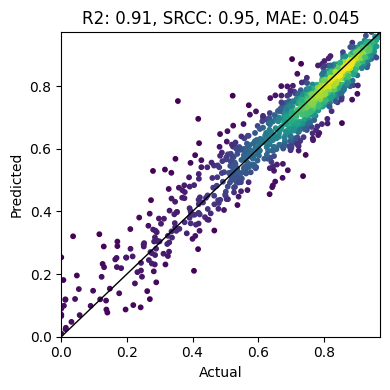

In [147]:
validate_loader, _ = prepare_hybrid_dataset(test_df,tokenized_info,target_names,pad_node=False,batch_size=1,shuffle=True,train=False,scaler=predictor_scaler,noise_level=predictor_train_info['noise_level'])
create_parity_plot(predictor_model, predictor_scaler, validate_loader)

(1000, 1)


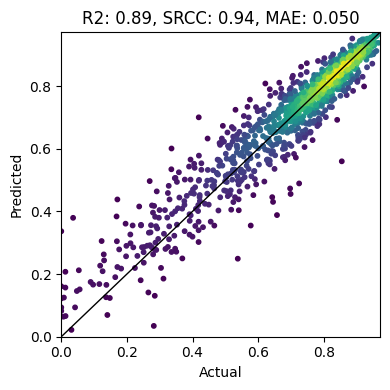

In [148]:
validate_loader, _ = prepare_hybrid_dataset(test_df,tokenized_info,target_names,pad_node=False,batch_size=1,shuffle=True,train=False,scaler=scaler,noise_level=dream_train_info['noise_level'])
create_parity_plot(dreaming_model, scaler, validate_loader)

# Dreaming 

Get dreaming seed and set target value

In [149]:
seed_mof_string = '[Cl][C][C][Branch][C][Branch][FrH0][pop][Ring1][Ring1][pop][FrH0][.][O][=C][Branch1][C][Fr][O][Tb][O][C][Branch1][C][Fr][O][Tb][Branch1][=Branch2][O][C][Branch1][C][Fr][O][Ring1][Branch1][Branch1][=Branch2][O][C][Branch1][C][Fr][O][Ring1][=C][Branch1][#Branch2][O][C][Branch1][C][Fr][O][Ring2][Ring1][C][O][C][Branch1][C][Fr][O][Ring2][Ring1][=Branch1][&&][pcu]'
idx = train_df[train_df['mof_string']==seed_mof_string].index.item()
target_values = [1] # maximisation

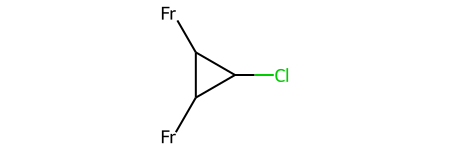

In [150]:
# What is the initial linker?
group_grammar.decoder(train_df.iloc[idx]['edge_group_selfie'])

Perform the optimisation

In [175]:
dream_settings = {
    'num_epochs': 1000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1,
    'patience': 50,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1,
    'contrain_sc': True
    }
valid_opt_pathway, transmutation_pathway, dreaming_losses = dream(
    dreaming_model,
    predictor_model,
    seed_mof_string,
    target_values,
    tokenized_info,
    group_grammar, 
    dream_settings,
    seed=100
    )

Restored variables from c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\SARKISOV_GROUP_REPOs\dreaming4MOFs\deep_dream_src\scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz
seed value: [0.42377335] | target value: [1.] | opt_flag: ['max']




c:\Users\x82753cc\AppData\Local\anaconda3\envs\TESTING_DREAMING_TEST\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


opt flag: max, all targets: [0.5734435], valid linker, valid distance point
opt flag: max, all targets: [0.5734435], valid linker, invalid distance point
opt flag: max, all targets: [0.5734435], valid linker, invalid distance point
opt flag: max, all targets: [0.5734435], valid linker, invalid distance point
opt flag: max, all targets: [0.5734435], valid linker, invalid distance point
opt flag: max, all targets: [0.7808333], valid linker, valid distance point
opt flag: max, all targets: [0.7808333], valid linker, invalid distance point
opt flag: max, all targets: [0.7808333], valid linker, invalid distance point
opt flag: max, all targets: [0.7808333], valid linker, invalid distance point
opt flag: max, all targets: [0.7808333], valid linker, invalid distance point
opt flag: max, all targets: [0.7808333], valid linker, invalid distance point
opt flag: max, all targets: [0.7808333], valid linker, invalid distance point
opt flag: max, all targets: [0.7808333], valid linker, invalid dista

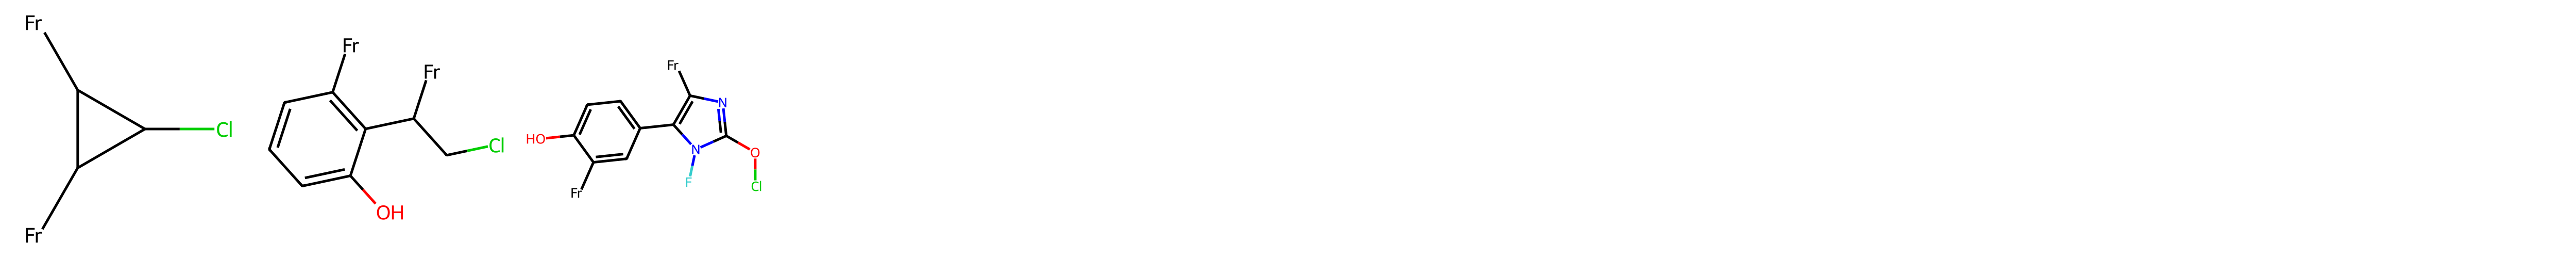

In [176]:
draw_smiles_linker(valid_opt_pathway['dreamed_smiles'],molsPerRow=10,subImgSize=(500,500),line_width=5)

What happens if we run it again? 

In [180]:
valid_opt_pathway, transmutation_pathway, dreaming_losses = dream(
    dreaming_model,
    predictor_model,
    seed_mof_string,
    target_values,
    tokenized_info,
    group_grammar, 
    dream_settings,
    seed=2
    )

Restored variables from c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\SARKISOV_GROUP_REPOs\dreaming4MOFs\deep_dream_src\scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz
seed value: [0.470811] | target value: [1.] | opt_flag: ['max']


opt flag: max, all targets: [0.368953], valid linker, invalid distance point
opt flag: max, all targets: [0.368953], valid linker, invalid distance point
opt flag: max, all targets: [0.368953], valid linker, invalid distance point
opt flag: max, all targets: [0.368953], valid linker, invalid distance point
opt flag: max, all targets: [0.368953], valid linker, invalid distance point
opt flag: max, all targets: [0.368953], valid linker, invalid distance point
opt flag: max, all targets: [0.368953], valid linker, invalid distance point
opt flag: max, all targets: [0.368953], valid linker, invalid distance point
opt flag: max, all targets: [0.368953], valid linker, invalid distance point
opt flag: max, all targets: [0.368953

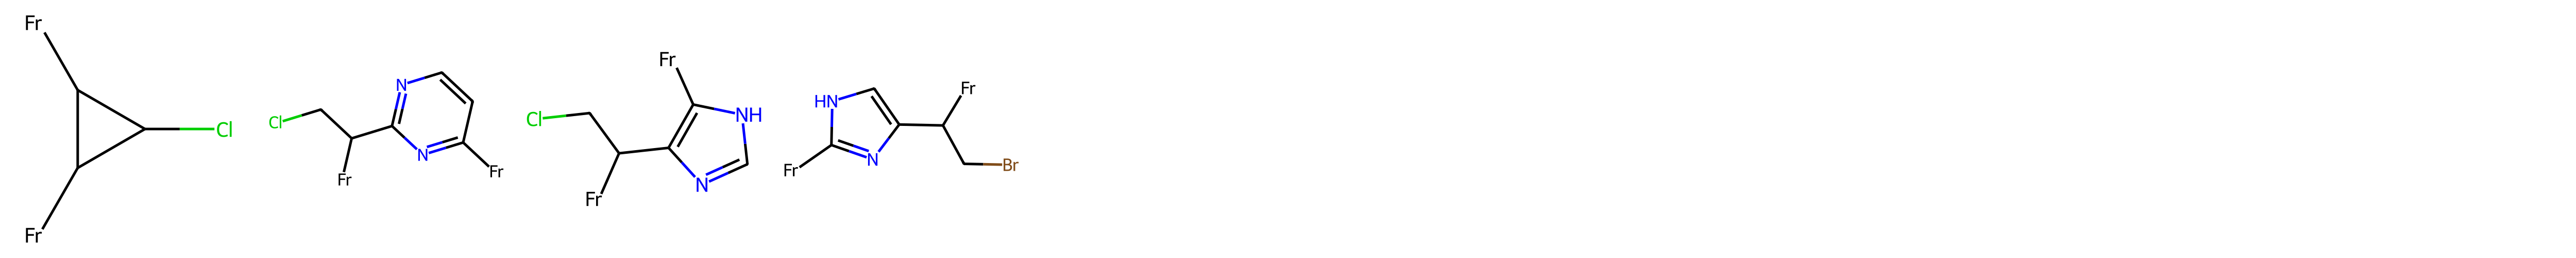

In [181]:
draw_smiles_linker(valid_opt_pathway['dreamed_smiles'],molsPerRow=10,subImgSize=(500,500),line_width=5)

We can see that the nature of the optimisation is stochastic. We therefore performed this optimisation 40 times using different seeds for random noise (i.e., 40 different optimisation outcomes, due to the stochastic nature of the model) 

In [8]:
import pickle

file_path = "./run_40_times/track_multiple_run.pkl"
with open(file_path, 'rb') as file:
    track_multiple_run = pickle.load(file)

In [9]:
dreamed_smiles = []
for opt_pathway in track_multiple_run:
    dreamed_smiles.append(opt_pathway.iloc[-1]['dreamed_smiles'])

In [12]:
from sklearn.manifold import TSNE
from utils import compute_fingerprints

# Generate fingerprints
seed_fps = compute_fingerprints([Chem.MolToSmiles(group_grammar.decoder(train_df.iloc[idx]['edge_group_selfie']))])
generated_fps = compute_fingerprints(dreamed_smiles)
reference_fps = compute_fingerprints(training_data['edge_canon_smile'].tolist())

# Combine fingerprints
all_fps = np.array(seed_fps + generated_fps + reference_fps)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=200, learning_rate=50, random_state=42)
reduced_data = tsne.fit_transform(all_fps)

# Split the transformed data for plotting
transformed_seed = reduced_data[:len(seed_fps), :]
transformed_generated = reduced_data[len(seed_fps):len(seed_fps)+len(generated_fps), :]
transformed_reference = reduced_data[len(seed_fps)+len(generated_fps):, :]


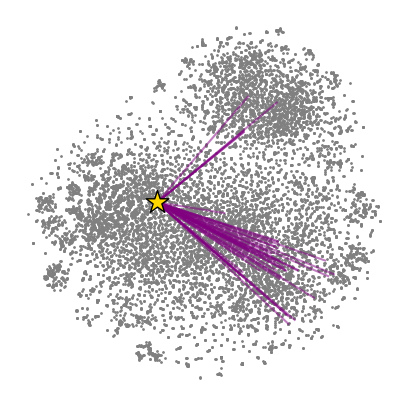

In [14]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(transformed_reference[:, 0], transformed_reference[:, 1], color='grey', s=1, label='Train linkers', zorder=-1)

for i in range(len(transformed_generated)):
    ax.plot([transformed_seed[0, 0], transformed_generated[i, 0]], [transformed_seed[0, 1], transformed_generated[i, 1]], color='purple', alpha=0.5, zorder=0)

ax.scatter(transformed_seed[:, 0], transformed_seed[:, 1], color='gold', marker='*', edgecolors='k', linewidths=1, s=300, label='Seed linker', zorder=1)

# Turn off box and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig('tSNE.png',dpi=300,bbox_inches="tight")
plt.show()


#### Shited property distributions

In [ ]:
# ******************* EXAMPLE CELL TO OPTIMISE DISTRIBUTION *******************

# Seed distribution
seed = pd.read_csv(('../seeds/POV_1000_seed_df.csv'))
target_values = [1]     # max(POV)

# Dream settings
dream_settings = {
    'num_epochs': 1000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1,
    'patience': 100,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1
    }

# Perform dreaming for a distribution of cp MOFs
dream_results = []
exceptions = []
start, stop = 0, 10
count = 0
for i in range(start,stop): 
    print(i)
    try:
        global_opt_pathways = []
        for j in range(10): 
            seed_mof_string = seed.iloc[i]['mof_string']
            opt_mof_string = seed_mof_string
            local_valid_opt_pathway = run_dream_exp(
                dreaming_model, 
                predictor_model, 
                opt_mof_string, 
                target_values, 
                tokenized_info, 
                group_grammar, 
                dream_settings,
                iterations=5
                )
            global_opt_pathways.append(local_valid_opt_pathway)
        
        # extract the pathway with the best target value (ensemble of local optimisations)
        if target_values[0] <= 0:
            valid_opt_pathway = global_opt_pathways[np.argmin([pathway.iloc[-1]['predictor_targets'][0] for pathway in global_opt_pathways])]
        elif target_values[0] >= 1:
            valid_opt_pathway = global_opt_pathways[np.argmax([pathway.iloc[-1]['predictor_targets'][0] for pathway in global_opt_pathways])]
        else:
            raise ValueError('Target value must be <= 0 or >= 1')

        # store results in new dataframe
        dream_results.append({
            'seed_mof_name': seed.iloc[i]['MOFname'],
            'seed_mof_string': seed_mof_string,
            'seed_edge_selfies': seed.iloc[i]['edge_group_selfie'],
            'seed_target': seed.iloc[i][target_names[0]],
            'dreamed_mof_string': valid_opt_pathway.iloc[-1]['dreamed_mof_string'],
            'dreamed_edge_selfies': valid_opt_pathway.iloc[-1]['dreamed_selfies'],
            'dreamed_edge_smiles': valid_opt_pathway.iloc[-1]['dreamed_smiles'],
            'dreamed_target': scaler.inverse_transform(np.array(valid_opt_pathway.iloc[-1]['predictor_targets'][0]).reshape(1, -1)).item(),
        })
        count += 1
        if count % 5 == 0:
            dream_results_df = pd.DataFrame(dream_results)
            dream_results_df.to_csv(f'./dream_results/{start}_{stop}_{target_names[0]}_dream_results_TEST.csv')    	
    except Exception as e:
        exceptions.append(e)
        continue
dream_results_df = pd.DataFrame(dream_results)
dream_results_df.to_csv(f'./dream_results/{start}_{stop}_{target_names[0]}_dream_results_TEST.csv')

#### Let's visualise the dreaming results

In [199]:
def filter_unique_matches(full_df, subset_df, column_name):
    """
    Filters rows from full_df by taking one row for each row in subset_df
    based on matching the specified column.

    Parameters:
        full_df (pd.DataFrame): The larger DataFrame (3000 rows).
        subset_df (pd.DataFrame): The smaller DataFrame (1000 rows).
        column_name (str): The column name to match for filtering.
    
    Returns:
        pd.DataFrame: A new DataFrame with rows from full_df that match the entries in subset_df.
    """
    # Initialize an empty list to store the matched rows
    matched_rows = []
    
    # Create a copy of the full_df to avoid modifying the original
    full_df_copy = full_df.copy()
    
    # Iterate over each row in the smaller DataFrame
    for _, row in subset_df.iterrows():
        mof_name = row[column_name]
        
        # Find the first matching row in the larger DataFrame
        match = full_df_copy[full_df_copy[column_name] == mof_name]
        if not match.empty:
            matched_row = match.iloc[0]  # Take the first matching row
            matched_rows.append(matched_row)
            
            # Drop the matched row from the full_df_copy to avoid reusing it
            full_df_copy = full_df_copy.drop(matched_row.name)
    
    # Create a new DataFrame from the matched rows
    filtered_df = pd.DataFrame(matched_rows)
    return filtered_df

In [ ]:
# Note: these are the results obtained after reconstructing MOFs from their strings and predicting the pore volume using zeo++
dream_results_df = pd.read_csv('./dream_results/POV_max_1000_dream_results.csv')
dream_results_df.head(1)    

,seed_mof_name,seed_mof_string,seed_edge_selfies,seed_target,dreamed_mof_string,dreamed_edge_selfies,dreamed_edge_smiles,dreamed_target,dreamed_mof_name,linker_hash
0,crb_N68_edge54441,[:0alkene][C][C][N][N][Branch][N][C][Branch][C...,[:0alkene][C][C][N][N][Branch][N][C][Branch][C...,0.682,[N][:1alkyne][:0alkene][:3pyridine][=Branch][:...,[N][:1alkyne][:0alkene][:3pyridine][=Branch][:...,NC#Cc1cnccc1-c1cnccc1-c1c(O)cc(C#Cc2ccnc(-c3c[...,0.849,crb_N68_ecf0b974,ecf0b974


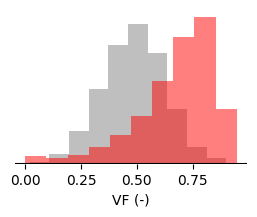

In [9]:
plt.figure(figsize=(3,2))
plt.hist(dream_results_df['seed_target'], bins=10, alpha=0.5, color='grey', label='seed', density=True)
plt.hist(dream_results_df['dreamed_target'], bins=10, alpha=0.5, color='red', label='max', density=True)
plt.xlabel('VF (-)')
# plt.legend()
plt.box(False)
plt.tick_params(left=False, labelleft=False)

# Add a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-')

plt.savefig('POV_dream_distributions.png',dpi=300,bbox_inches='tight')

#### Comparing results before and after structural relaxation

To evaluate the impact that structural relaxation has on the predicted property values, we sampled a representative subset of 100 seed MOFs (and their optimised counterparts) and relaxed their crystal structures using the UFF forcefield as implemented in the Forcite Module of Materials Studio 2019. The results are shown below

In [212]:
# Note: these are the results obtained after reconstructing MOFs from their strings and using zeo++ to determine the high-fidelity properties
pov_max_relaxed = pd.read_csv('./dream_results/POV_max_100_dream_results_relaxed.csv')
pov_max_unrelaxed = pd.read_csv('./dream_results/POV_max_100_dream_results_unrelaxed.csv')

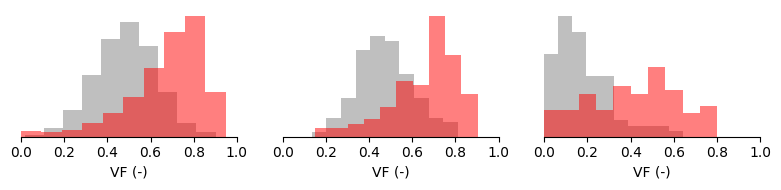

In [368]:
fig, ax = plt.subplots(1,3, figsize=(8, 2))

ax[0].hist(dream_results_df['seed_target'], bins=10, color='grey', alpha=0.5, density=True, label='Original seed')
ax[0].hist(dream_results_df['dreamed_target'], bins=10, color='red', alpha=0.5, density=True, label='Original dreamed')
# ax[0].set_title('Original Histograms')
ax[0].set_xlabel('VF (-)')
ax[0].set_xlim(0,1)
# ax[0].legend(frameon=False)

ax[1].hist(pov_max_unrelaxed['seed_target'], bins=10, color='grey', alpha=0.5, density=True, label='Sampled seed')
ax[1].hist(pov_max_unrelaxed['dreamed_target'], bins=10, color='red', alpha=0.5, density=True, label='Sampled dreamed')
# ax[1].set_title('Sampled Histograms')
ax[1].set_xlabel('VF (-)')
ax[1].set_xlim(0,1)
# ax[1].legend(frameon=False)

ax[2].hist(pov_max_relaxed['seed_target'], bins=10, color='grey', alpha=0.5, density=True, label='Original seed')
ax[2].hist(pov_max_relaxed['dreamed_target'], bins=10, color='red', alpha=0.5, density=True, label='Original dreamed')
# ax[2].set_title('Relaxed Histograms')
ax[2].set_xlabel('VF (-)')
ax[2].set_xlim(0,1)

# ax[2].legend(frameon=False)

for a in ax:
    a.yaxis.set_ticks([])
    a.yaxis.set_ticklabels([])
    a.set_ylabel('')
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()
# plt.savefig('POV_relaxed_distributions.png',dpi=300,bbox_inches='tight')